This notebook is here to visualize the process which happens in the creation of the bounding boxes. To work with it adjust the data according to the reference scan or rescan that is desired. Keep in mind that here the bounding boxes are already in the correct coordinate system/ aligned in the reference coordinate system since the data was prepsocessed -> no need to adjust the bounding boxes. However the transformation into the ref coordinate system was implemented/tested here so the code can be found here

In [37]:
import pickle
import os 
import os.path as osp
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import random
import open3d as o3d
import json
import subprocess

#the other imports from the local stuff
import sys

ws_dir = '/local/home/ekoller/BT'
print(ws_dir)
sys.path.append(ws_dir)
from utils import scan3r,visualisation

/local/home/ekoller/BT


In [38]:
#visualization and computation of the boundingbox with a toy example soo see that we don't so weird shapes or smth

def computationBoundingbox():
    #can throwaway that file this is just to tryout
    #try out if the matrix transformations worked the way we expected them to
    array = [1,0,0,0,0,-1,0,1,0]
    res = np.reshape(array, (3, 3), order='F') 
    print("collumnwise:" ,res);

    resrow = np.reshape(array, (3, 3)) 
    print("rowumnwise:" ,resrow);

    lengths = [1, 1, 1]
    #correct obne
    reslength = res.dot(lengths);
    print(reslength)

    #the incorrect one
    rowreslength = resrow.dot(lengths);
    print(rowreslength)



    # Define parameters

    centroid = np.array([0, 0, 0])

    # Calculate half lengths
    half_lengths = reslength / 2.0

    # Calculate corner points: firsto top 4 corners then the bottom ones
    corners = np.array([
        centroid + np.array([-1, -1, -1]) * half_lengths,  # Corner 0
        centroid + np.array([+1, -1, -1]) * half_lengths,  # Corner 1
        centroid + np.array([-1, +1, -1]) * half_lengths,  # Corner 2
        centroid + np.array([+1, +1, -1]) * half_lengths,  # Corner 3
        centroid + np.array([-1, -1, +1]) * half_lengths,  # Corner 4
        centroid + np.array([+1, -1, +1]) * half_lengths,  # Corner 5
        centroid + np.array([-1, +1, +1]) * half_lengths,  # Corner 6
        centroid + np.array([+1, +1, +1]) * half_lengths   # Corner 7
    ])
    
   

    # Plot the bounding box
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot box edges
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  # Bottom face
        [4, 5], [5, 7], [7, 6], [6, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Connecting edges
    ]
    for edge in edges:
        ax.plot3D(
            [corners[edge[0], 0], corners[edge[1], 0]],
            [corners[edge[0], 1], corners[edge[1], 1]],
            [corners[edge[0], 2], corners[edge[1], 2]],
            color='b'
        )

     # Annotate each corner with its index
    for i, corner in enumerate(corners):
        ax.text(corner[0], corner[1], corner[2], f'{i}', color='red')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Bounding Box')

    plt.show()
               

In [58]:
scan_id = "02b33dfb-be2b-2d54-92d2-cd012b2b3c40"
data_dir = '/local/home/ekoller/R3Scan'
frame_id = "000002"
bounding_boxes = [] 
json_bounding_box = osp.join(data_dir, 'scenes', scan_id, 'semseg.v2.json')
with open(json_bounding_box, 'r') as file:
            data = json.load(file)

            for object in data['segGroups']:
                #get the current id
                if object["objectId"] == 3:
                    print("inside")
                    # the axes lengths give the length in each direction of one axis -> from centroid we have to move in 
                    # both  directions of x in + and -
                    axes_lengths = object['obb']['axesLengths']

                    # the normaliyed axis are the directions in which the boundingbox points to in comparison to the coord system
                    #we can use them to create a transformationmatrix! every row is one of the vector
                    normalized_axes = object['obb']["normalizedAxes"]

                    #construct the matrix using collumnformat ( each vecor becomes a collumn based on 2d example)
                    matrix = np.reshape(normalized_axes, (3,3), order= "F")

                    #compute the new axislengths
                    lengths = matrix.dot(axes_lengths)
                    
                    #the centriod of the object
                    centroid = object['obb']["centroid"]

                    # calculate the new points one time in + direction one time in -
                    # get half of the lengths to add in each direction
                    points = np.zeros
                    half_lengths = lengths / 2.0

                    #not pretty bus shows clearly where it is going looks like the following BT/Illustrations
                    corners = np.array([
                    centroid + np.array([+1, +1, -1]) * half_lengths, #1
                    centroid + np.array([-1, +1, -1]) * half_lengths, #5
                    centroid + np.array([-1, -1, -1]) * half_lengths, #7
                    centroid + np.array([+1, -1, -1]) * half_lengths, #3
                    centroid + np.array([+1, +1, +1]) * half_lengths, #0
                    centroid + np.array([-1, +1, +1]) * half_lengths, #4
                    centroid + np.array([-1, -1, +1]) * half_lengths, #6
                    centroid + np.array([+1, -1, +1]) * half_lengths, #2  
                    ])
                    #add the cornerarray of the object to the bounding box
                    bounding_boxes.append(corners)

inside


collumnwise: [[ 1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]
rowumnwise: [[ 1  0  0]
 [ 0  0 -1]
 [ 0  1  0]]
[ 1  1 -1]
[ 1 -1  1]


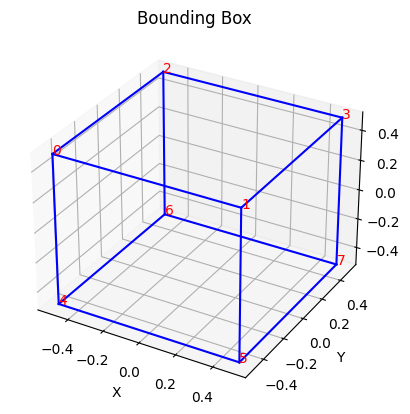

In [39]:
#compute the computation of boundingbox
computationBoundingbox()

In [40]:
#lowkey unnecessary lol can simply initialize an np array but whatever the brain wasnt braining butis already integrated
def getArrayOfArray(rows,cols):

    array_of_arrays = [[0] * cols for _ in range(rows)]

    # Initialize an array of arrays with None
    array_of_arrays = [[None] * cols for _ in range(rows)]

    # Initialize an array of arrays with empty lists
    array_of_arrays = [[] for _ in range(rows)]
    return array_of_arrays

In [41]:
#not really used maybe buggy who knows, was meant for the 2d projection of the boxes but there was/ is an issue
def check_if_in_img(img_corners, idx, list, listidx, badlistidx):
    total_in_img = True
    for corner in img_corners:
            if  not ((0 <= corner[0] <= 960) and (0 <= corner[1] <= 540)):
                total_in_img = False

    if total_in_img and (not idx in badlistidx):
        print("this box is entirely in the image:", idx, "with values:" ,img_corners)
        list.append(img_corners)
        listidx.append(idx)

In [42]:
#this function returns a np array with a random rgb value, can also np.random.rand(3)
def get_random_color():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return np.array([r, g, b])

In [43]:
#given a Reference and a Rescan plotts both pointclouds each in one colour and the corresponding bounding boxes with the already precomputed data in pkl
#if both rescans, both will be plotted in the reference scan coordinates, why do we know that: pointclouds are aligned to referencescan (thanks Yang) and the boundingboxes fit
vis = o3d.visualization.Visualizer()
vis.create_window()

#load the data 1 referenc cloud and box
pklfile = osp.join('/local/home/ekoller/R3Scan', 'files', 'orig', 'data', '{}.pkl'.format("1d2f8510-d757-207c-8c48-3684433860e1") )
with open(pklfile, "rb") as f:
        # Load the data
        data = pickle.load(f)
        pointclouds_1 = data['obj_points'][512]
        bounding_boxes_1 = data['bounding_boxes'] 

#load the data 2 rescan  cloud and box
pklfile = osp.join('/local/home/ekoller/R3Scan', 'files', 'orig', 'data', '{}.pkl'.format("9c27de56-6184-2cda-8196-591957b6387d") )
with open(pklfile, "rb") as f:
        # Load the data
        data = pickle.load(f)
        pointclouds_2 = data['obj_points'][512]
        bounding_boxes_2 = data['bounding_boxes'] 
    

# Add each point cloud with its corresponding color 1 // reference

for points in pointclouds_1:
        #color = np.random.rand(3)
        color = np.array([0,255,0])
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        #color_vector = o3d.utility.Vector3dVector(color.astype(np.float64))
        pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(points), 1))) 
        vis.add_geometry(pcd)



# Add each point cloud with its corresponding color 2 // rescan
for points in pointclouds_2:
        #color = np.random.rand(3)
        color = np.array([255,0,0])
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        #color_vector = o3d.utility.Vector3dVector(color.astype(np.float64))
        pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(points), 1))) 
        vis.add_geometry(pcd)

#define the edges
edges = [ 
    [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
    [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
    [0, 4], [1, 5], [2, 6], [3, 7]   # Connecting edges
    ]

#convert the boundinbox into the new coordinate system // not necessary nos since the accessed data got preprocessed with this function
# bounding_boxes_2 = scan3r.get_box_in_ref_coord('/local/home/ekoller/R3Scan',bounding_boxes_2, "fcf66d8a-622d-291c-8429-0e1109c6bb26")

#add boundingboxes 1 // reference
for bbox in bounding_boxes_1:
        bbox_color = np.array([0,255,0])
        line_set = o3d.geometry.LineSet()
        line_set.points.extend(o3d.utility.Vector3dVector(bbox))
        line_set.lines.extend(o3d.utility.Vector2iVector(edges))
        line_set.colors = o3d.utility.Vector3dVector([bbox_color] * len(edges))
        vis.add_geometry(line_set)

#add boundingboxes 2 // rescan
for bbox in bounding_boxes_2:
        bbox_color = np.array([255,0,0])
        line_set = o3d.geometry.LineSet()
        line_set.points.extend(o3d.utility.Vector3dVector(bbox))
        line_set.lines.extend(o3d.utility.Vector2iVector(edges))
        line_set.colors = o3d.utility.Vector3dVector([bbox_color] * len(edges))
        vis.add_geometry(line_set)

# Run the visualizer
vis.run()
vis.destroy_window()

In [44]:
#function: given a pointcloud, boundingboxes, centers and camera coord plots the pointcoud parts in different colours and the boundingboxes in black plus camera position
def visualize_point_clouds(point_clouds, bounding_boxes, centers, camera_coord):
    # Create a blank scene
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Add each point cloud with its corresponding color
    for points in point_clouds:
        color = np.random.rand(3)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        #color_vector = o3d.utility.Vector3dVector(color.astype(np.float64))
        pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(points), 1))) 
        vis.add_geometry(pcd)

    #add the center also into the coordinatesystem
    color = np.array([0,0,0])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(centers)
    pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(centers), 1)))
    vis.add_geometry(pcd)

    #add the camera pose into the coordinate system
    color = np.array([0,0,0])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(camera_coord)
    pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(camera_coord), 1)))
    vis.add_geometry(pcd)

    #define the edges
    edges = [ 
    [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
    [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
    [0, 4], [1, 5], [2, 6], [3, 7]   # Connecting edges
    ]
    for bbox in bounding_boxes:
        line_set = o3d.geometry.LineSet()
        line_set.points.extend(o3d.utility.Vector3dVector(bbox))
        line_set.lines.extend(o3d.utility.Vector2iVector(edges))
        vis.add_geometry(line_set)


    # Run the visualizer
    vis.run()
    vis.destroy_window()



In [45]:
#return true if it is rescan
def is_rescan(data_dir,scan_id):

    is_rescan = True
    dir_path = osp.join(data_dir,"files","3RScan.json")
    with open(dir_path, 'r') as file:
        data = json.load(file)
        #get the reference scans
        reference_scans = [item["reference"] for item in data]
    
    if scan_id in reference_scans:
        is_rescan = False

    return is_rescan


#return true if it is reference
def is_reference(data_dir,scan_id):

    is_ref = False
    dir_path = osp.join(data_dir,"files","3RScan.json")
    with open(dir_path, 'r') as file:
        data = json.load(file)
        #get the reference scans
        reference_scans = [item["reference"] for item in data]
    
    if scan_id in reference_scans:
        is_ref = True

    return is_ref


    

#sanity check
print(is_rescan("/local/home/ekoller/R3Scan","02b33df9-be2b-2d54-9062-1253be3ce186"))
print(is_reference("/local/home/ekoller/R3Scan","fcf66d8a-622d-291c-8429-0e1109c6bb26"))



True
False


In [46]:
#given a transformation matrix, a box and dim transforms the boundinbox coordinates into the new coordinate system which is given by transform
#dim == 2 meand that the point is a 2d point -> 3d homog coord
#dim == 3 means the the point is a 3d point -> 4c homog coord
def coord_to_ref(transform, box, dim):
    #turn to homog coord
    if dim == 2:
        points4f = np.insert(box, 2, values=1, axis=1)  # Insert 1 as the third coordinate for 2D points
    elif dim == 3:
        points4f = np.insert(box, 3, values=1, axis=1) 

    #compute the transromation
    transformed_points = np.dot(points4f, transform)

    #write the result back
    for i in range(len(box)):
        #the matrix indeed results in a 1 in the 4th coordinate
        #print("undehomogenized point", transformed_points[i])
        box[i] = transformed_points[i, :3] 

    return box


In [47]:
# transform from rescan to reference coordinates, if the given scan Id is reference, return old boxes
#attention! in place opearation
def get_box_in_ref_coord( data_dir,bounding_boxes, scan_id):
    
    if is_rescan(data_dir,scan_id):
        #transformthe box of the rescan to ref coord
        path = osp.join(data_dir,"files", "3RScan.json")
        map_id_to_trans = scan3r.read_transform_mat(path)
        transform = map_id_to_trans[scan_id]
        transform = transform.reshape(4,4)
        for i,box in enumerate(bounding_boxes):
                bounding_boxes[i] = coord_to_ref(transform, box,3)
           

    return bounding_boxes


In [48]:
# transform centers from rescan to reference coordinates!
#attention  in place
def get_center_in_ref_coord(data_dir,centers, scan_id):
    
    if is_rescan(data_dir,scan_id):
        #transform the centers of rescan to ref coord
        path = osp.join(data_dir,"files", "3RScan.json")
        map_id_to_trans = scan3r.read_transform_mat(path)
        transform = map_id_to_trans[scan_id]
        transform = transform.reshape(4,4)
        centers = coord_to_ref(transform, centers,3)
        centers= np.vstack(centers)
        

    return centers

In [49]:
#transform the camera coord into the reference coordinates
def get_camera_in_ref_coord(data_dir,camera_coord, scan_id):
    #camera coord is a list of one element of size 3
    camera_coord = get_center_in_ref_coord(data_dir,camera_coord, scan_id)
    return camera_coord

In [59]:
#loading of the boundingboxes, pointcloud and camera points and visualizes it  fail with "fcf66d8a-622d-291c-8429-0e1109c6bb26"
#"fcf66d9e-622d-291c-84c2-bb23dfe31327"
#parameters
scan_id = "02b33dfb-be2b-2d54-92d2-cd012b2b3c40"
data_dir = '/local/home/ekoller/R3Scan'
frame_id = "000002"


#load the boundingboxdata as it got saved
pklfile = osp.join(data_dir, 'files', 'orig', 'data', '{}.pkl'.format(scan_id) )
with open(pklfile, "rb") as f:
    # Load the data
    data = pickle.load(f)
    pointclouds = data['obj_points'][512]
    bounding_boxes = data['bounding_boxes'] 

   
    obj_count = data['objects_count']
    obj_id = data['objects_id']
    obj2idx = data['object_id2idx']

    print("object count:", obj_count)
    print("object id length", len(obj_id))
    print("obj ids pkl", obj_id)
    print("bounding_boxes", len(bounding_boxes))
    print("length of obj2idx", len(obj2idx))
    print("obj2idx", obj2idx)


    plydata_npy = np.load(osp.join(data_dir,"scenes", scan_id, "data.npy"))
    obj_labels = plydata_npy['objectId']
    unique_obj_labels = np.unique(obj_labels)

    print(" uniquobj labels used for ray intersection length", len(unique_obj_labels))
    print("unique obj id ray intersection", unique_obj_labels)

    #test for different ids
    all_ids = []
    removed_ids = []

    #acccess the centers of the boundinbox
    centers = getArrayOfArray(len(obj_id),3)

#important to do: ask yang why here the object id amound does not align with the object id number id got from the semseg

    json_bounding_box = osp.join(data_dir, 'scenes', scan_id, 'semseg.v2.json')
    with open(json_bounding_box, 'r') as file:
        data = json.load(file)
        i = 0
        for object in data['segGroups']:

            all_ids.append(object["objectId"])

            #check if the object is also in the list
            if object["objectId"] in obj_id:
                #the centriod of the object
                centroid = object['obb']["centroid"]
                #print("center of object:", centroid)
                centers[i] = centroid
                i = i + 1
                
            else:
                removed_ids.append(object["objectId"] )


print("all ids length",len(all_ids), "values", all_ids)  
print("remove ids length", len(removed_ids), "values", removed_ids)  
print("bounding_boxes", bounding_boxes)      
#print("all centers", centers)

#print("pointclouds pkl info", pointclouds)
#2d visualization
#plot_point_clouds(pointclouds)

#also add the camera pose to see in which coordinate system it is given
camera_pos_path = osp.join(data_dir, 'scenes', scan_id, 'sequence', 'frame-{}.pose.txt'.format(frame_id))

with open(camera_pos_path, "r") as f:
            #get the world to camera matrix transformation
            camera_to_world = np.loadtxt(f, dtype=np.float64)
            #print("camera to world matrix", camera_to_world)
            camera_to_world = camera_to_world.reshape(4,4)
            #get the last column
            last_column = camera_to_world[:, -1]
            camera_coord = last_column[:-1]
            camera_coord = np.array([camera_coord])
            #print("camera coord",  camera_coord)


#adjust camera coord, bounding box and center to the ref coordinates // already happened
#camera_coord = get_camera_in_ref_coord(data_dir, camera_coord, scan_id)
#bounding_boxes = get_box_in_ref_coord(data_dir,bounding_boxes,scan_id)



#in our data we only save the boundingboxes no the centers hence need to adjust them here
centers = get_center_in_ref_coord(data_dir, centers, scan_id)
#print("centers dehomog", centers)
#print("new boundingboxes", bounding_boxes)




#3d visualization
visualize_point_clouds(pointclouds, bounding_boxes, centers, camera_coord)


#current problem: we have one boundingbox too much in the data -> probably the floor see how you can remove that one
#in files obj.jason we have the objects and their namesand id



object count: 25
object id length 25
obj ids pkl [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 22 23 26 27 28 29
 30]
bounding_boxes 25
length of obj2idx 25
obj2idx {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 20: 17, 22: 18, 23: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24}
 uniquobj labels used for ray intersection length 29
unique obj id ray intersection [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25
 26 27 28 29 30]
all ids length 28 values [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 27]
remove ids length 3 values [21, 24, 25]
bounding_boxes [array([[ 0.93681313,  1.19776025, -1.42585999],
       [-0.81697552,  1.19776025, -1.42585999],
       [-0.81697552, -0.90397692, -1.42585999],
       [ 0.93681313, -0.90397692, -1.42585999],
       [ 0.93681313,  1.19776025, -1.14226992],
       [-0.81697552,  1.19776025, -1.14226992

In [10]:
#given an image plot the boundingboxes of the objects in 2d 
#this code is not working!!!!!!!
def showBoundingoxes(r3scan_dir, scan_id, scan_id_pkl, frame_id_color, frame_id_pose):
    
    #get the camera intrinsics
    camera_info = scan3r.load_intrinsics('/local/home/ekoller/R3Scan/scenes', scan_id)
    #this matrix is the transformation from camera to image coordinates
    cam_to_img = camera_info['intrinsic_mat']
    img_width = int(camera_info['width'])
    img_height = int(camera_info['height'])

    print("camera to image matrix:" , cam_to_img)
    print("imagewidth", img_width)
    print("img height:", img_height)


    #load the matrix from world to camera coordinates (4x4 matrix needing homogenious coordinates)
    world_info = osp.join(r3scan_dir, 'scenes', scan_id, 'sequence', frame_id_pose)

    print("World_info path", world_info)

    with open(world_info, "r") as f:
            #get the world to camera matrix transformation
            world_to_camera = np.loadtxt(f, dtype=np.float64)
            world_to_camera = np.linalg.inv(world_to_camera) 
            # Use np.float64 as the data type
            print("Size of array read from file:", world_to_camera.size)  # Debugging output
            print("Content of array read from file:", world_to_camera)   # Debugging output
            world_to_camera = world_to_camera.reshape(4, 4)
            print("world to camera matrix:", world_to_camera)  # Debugging output

    #load the image data
    rgb = mpimg.imread(osp.join(r3scan_dir, 'scenes', scan_id, 'sequence', frame_id_color))

    print(osp.join(r3scan_dir, 'scenes', scan_id, 'sequence', frame_id_color))


    #get the shape of the image 
    height, width, channels = rgb.shape
    print("rgb width", width)
    print("rgb height ", height)
    assert(height == img_height)
    assert(width == img_width)
    
    print("image path", osp.join(r3scan_dir, 'scenes', scan_id, 'sequence', frame_id_color))

    #print the image in of form
    plt.imshow(rgb)
    #plt.axis('off')  #Turn off axis
    plt.show()


    #load the boundingboxdata
    pklfile = osp.join(r3scan_dir, 'files', 'orig', 'data', scan_id_pkl)
    with open(pklfile, "rb") as f:
        # Load the data
        data = pickle.load(f)
        bounding_boxes = data['bounding_boxes'] 
        

    # Access the "bounding_boxes" data
    bounding_boxes = data["bounding_boxes"]
    #print("all boundingboxes", bounding_boxes)


    #save a list of in image objects
    good_boxes =list()
    good_boxes_idx =list()
    background_boxes_idx = list()
  
    #iterate through every boundingbox
    #initialize index for each object
    idx = 0
    for box in bounding_boxes:
        #initialize the new corner
        img_corners = getArrayOfArray(8,2)
        i = 0
        for point in box:
            point = np.array(point)
            #trun the point into a homog point
            homog_world = np.append(point,1)
            #get the homog coord in the camera coord system
            homog_cam = np.dot(world_to_camera,homog_world)

            #normalize just in case
            homog_cam = homog_cam/ homog_cam[2]

            #last entry should always be 1, remove it
            #print("homog camera coord", homog_cam)
            cam_coord = homog_cam[:-1]
            #print("camera coord", cam_coord)

            #project from camea to image plane
            homog_img = np.dot(cam_to_img,cam_coord)

            #since the matrix and point are 3x3 we get a 3 long vector
            #print("homog image coord", homog_img)

            #turn the vector into a normal 2D coordinate
            #if the last entry is negative: the object is behind the camera -> should not get projected

            """
            Watch out! we already say that it is in the background only is one coordinate is in the background!!!!
            """
            if homog_img[2] < 0:
                background_boxes_idx.append(idx)


            homog_img = homog_img/ homog_img[2]
            #print("image coord for the boxpoint", homog_img)
            
            #take only first 2
            img_coord = homog_img[:-1]
            #add it to the corners
            img_corners[i] = img_coord
            i = i + 1


        print("img_corners after the loop execution", img_corners)
        #check if it is displayed in the image
        check_if_in_img(img_corners, idx, good_boxes, good_boxes_idx,background_boxes_idx)
        #go to the next idx of the object
        idx = idx+ 1

        #print("The final coordinates for the object", img_corners)

    #print the good list
    print("the amount of objects enitely inimage are",len(good_boxes_idx), "the idx of the objects are",good_boxes_idx, "the box values are", good_boxes)

     
    #print the boundingboxes which are on the image into the image
    plt.imshow(rgb)

    #draw the boxes
    for box in good_boxes:
        drawn_box = patches.Polygon(box, closed=True, fill=None, edgecolor='r', linewidth=2)
        plt.gca().add_patch(drawn_box)
    
    plt.show()
    

camera to image matrix: [[756.832   0.    492.889]
 [  0.    756.026 270.419]
 [  0.      0.      1.   ]]
imagewidth 960
img height: 540
World_info path /local/home/ekoller/R3Scan/scenes/0ad2d382-79e2-2212-98b3-641bf9d552c1/sequence/frame-000039.pose.txt
Size of array read from file: 16
Content of array read from file: [[-0.56141816 -0.30120648 -0.77076821  0.13850378]
 [-0.37845767  0.92175011 -0.08454497 -0.04797885]
 [ 0.73592109  0.24423823 -0.63148053 -0.34353065]
 [ 0.          0.          0.          1.        ]]
world to camera matrix: [[-0.56141816 -0.30120648 -0.77076821  0.13850378]
 [-0.37845767  0.92175011 -0.08454497 -0.04797885]
 [ 0.73592109  0.24423823 -0.63148053 -0.34353065]
 [ 0.          0.          0.          1.        ]]
/local/home/ekoller/R3Scan/scenes/0ad2d382-79e2-2212-98b3-641bf9d552c1/sequence/frame-000039.color.jpg
rgb width 960
rgb height  540
image path /local/home/ekoller/R3Scan/scenes/0ad2d382-79e2-2212-98b3-641bf9d552c1/sequence/frame-000039.color.jp

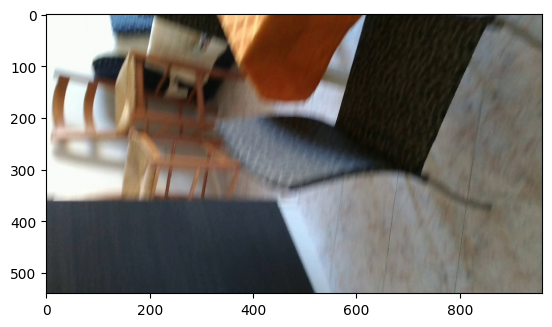

img_corners after the loop execution [array([ 400.35107804, -876.11011244]), array([-986.54610735, 1291.43496688]), array([-3502.98265732, -7151.83411598]), array([142.77065971, 349.18634795]), array([ 351.05449104, -936.63293412]), array([-796.08838128, 1218.53964388]), array([-1901.32969221, -4702.46969701]), array([100.53667698, 348.44197478])]
img_corners after the loop execution [array([ 336.59041216, -296.45657601]), array([ 449.04120604, -344.01397518]), array([295.00271795, 256.48576515]), array([226.36436719, 188.68316681]), array([ 126.50085396, -426.41125775]), array([ 197.49319949, -530.0597405 ]), array([ 64.2917469 , 232.80021437]), array([ 33.01157241, 158.96365415])]
img_corners after the loop execution [array([ 229.72825915, -216.83986966]), array([ 4232.54464534, -1471.17744098]), array([ 822.41694109, 1881.8879436 ]), array([119.64531453, 331.84678073]), array([-834.01669242, -744.24351868]), array([904.08776363, 707.08258366]), array([ 2203.81332815, -1628.89875812]

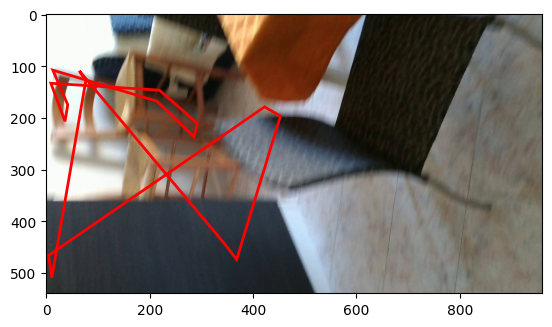

In [9]:
#compute the projection of the boundingboxes onto the image
showBoundingoxes('/local/home/ekoller/R3Scan', "0ad2d382-79e2-2212-98b3-641bf9d552c1" , "0ad2d382-79e2-2212-98b3-641bf9d552c1.pkl" ,"frame-000039.color.jpg", "frame-000039.pose.txt")